### Heat equation
Physics form:
$$\frac{\partial u(t,x)}{\partial t} + u(t,x) \frac{\partial u(t,x)}{\partial x} = \nu \frac{\partial^2 u(t,x)}{\partial x^2}$$
$u(t,x)$: velocity of fluid, $\nu$: viscosity of fluid <br><br>

General form:
$$\frac{\partial u(t,x)}{\partial t} + \lambda _{1} u(t,x) \frac{\partial u(t,x)}{\partial x} -\lambda _{2} \frac{\partial^2 u(t,x)}{\partial x^2} = 0$$<br>

In Maziar Raissi, Paris Perdikaris, and George Em Karniadakis paper: <br>
$$\frac{\partial u(t,x)}{\partial t} + u(t,x) \frac{\partial u(t,x)}{\partial x} -\frac{0.01}{\pi} \frac{\partial^2 u(t,x)}{\partial x^2} = 0$$ <br>
$$u(0,x) = -sin(\pi x) \textrm{, which is the initial condition}$$ <br>
$$u(t,-1) = u(t,1) = 0 \textrm{, which is the Dirichlet boundary conditions}$$<br>
$$x \in [-1,1], \textrm{ }t\in [0,1]$$
Close to the exact solution is $u(t,x) = e^{-t}sin(\pi x)$, [here is the exact analytical solution.](https://www.sciencedirect.com/science/article/abs/pii/0045793086900368)

### lol no that's the wrong equation :)

In [5]:
import math
import numpy as np
np.random.seed(0)

### DNN

In [6]:
import torch
from torch import nn 
from collections import OrderedDict
torch.manual_seed(0)

class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(len(layers) - 2): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (len(layers) - 2), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)

        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out
    

### PINN

In [16]:
import torch.optim as optim

class PINN():
    def __init__(self, layers, x, t, a, tol=1e-5, hs=50, verbose=False): 
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.verbose = verbose
        if self.verbose:
            print(f"device used: {self.device}")
            print(f"xt_train shape: {xt_train.shape}")
            print(f"xt_f shape: {xt_f.shape}")
            print(f"u_train shape: {u_train.shape}")
        
        self.net = DNN(layers).to(self.device)
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)

        
        # 500*500*500 points evaluated over entire grid (x,t,a) - exact solutions
        # we will give some of the points to model as support points to help convergence
        # grid of all points
        x_inter, t_inter, a_inter = np.meshgrid(x, t, a)
        # vector of point tuples(x,t,a)
        grid_exact = np.hstack((x_inter.flatten()[:,None], t_inter.flatten()[:,None], a_inter.flatten()[:,None])) 
        
        # corresponding f(x,t,a) evaluated with known exact result
        f_grid_exact = self.f_exact(grid_exact[:,0], grid_exact[:,1], grid_exact[:,2])
        
        
        # generate collocation points
        N_col = 100
        xcol = x[:N_col]
        tcol = t[:,:N_col,:]
        acol = a[:,:,:N_col]
        x_inter, t_inter, a_inter = np.meshgrid(xcol, tcol, acol)
        grid_col = np.hstack((x_inter.flatten()[:,None], t_inter.flatten()[:,None], a_inter.flatten()[:,None])) 
        
        self.col_x_tensor = torch.tensor(grid_col[:,0], requires_grad=True).float().to(self.device)
        self.col_t_tensor = torch.tensor(grid_col[:,1], requires_grad=True).float().to(self.device)
        self.col_a_tensor = torch.tensor(grid_col[:,2], requires_grad=True).float().to(self.device)
        
        
        
        # generate grids for boundary conditions:

        # 1. x=0 and x=pi boundary points
        # initial condition points(x=0)
        x_inter, t_inter, a_inter = np.meshgrid(0, t, a)
        x0_grid = np.hstack((x_inter.flatten()[:,None], t_inter.flatten()[:,None], a_inter.flatten()[:,None])) 
        
        self.x0_x_tensor = torch.tensor(x0_grid[:,0], requires_grad=True).float().to(self.device)
        self.x0_t_tensor = torch.tensor(x0_grid[:,1], requires_grad=True).float().to(self.device)
        self.x0_a_tensor = torch.tensor(x0_grid[:,2], requires_grad=True).float().to(self.device)

        
        # final condition points (x=pi)
        x_inter, t_inter, a_inter = np.meshgrid(math.pi, t, a)
        xpi_grid = np.hstack((x_inter.flatten()[:,None], t_inter.flatten()[:,None], a_inter.flatten()[:,None])) 
        
        self.xpi_x_tensor = torch.tensor(xpi_grid[:,0], requires_grad=True).float().to(self.device)
        self.xpi_t_tensor = torch.tensor(xpi_grid[:,1], requires_grad=True).float().to(self.device)
        self.xpi_a_tensor = torch.tensor(xpi_grid[:,2], requires_grad=True).float().to(self.device)


        
        # 2. t=0 initial condition points
        x_inter, t_inter, a_inter = np.meshgrid(x, 0, a)
        t0_grid = np.hstack((x_inter.flatten()[:,None], t_inter.flatten()[:,None], a_inter.flatten()[:,None])) 
        
        self.t0_x_tensor = torch.tensor(t0_grid[:,0], requires_grad=True).float().to(self.device)
        self.t0_t_tensor = torch.tensor(t0_grid[:,1], requires_grad=True).float().to(self.device)
        self.t0_a_tensor = torch.tensor(t0_grid[:,2], requires_grad=True).float().to(self.device)


        
        # 3. a=0 and a=1 boundary points
        # initial condition points(a=0)
        x_inter, t_inter, a_inter = np.meshgrid(x, t, 0)
        a0_grid = np.hstack((x_inter.flatten()[:,None], t_inter.flatten()[:,None], a_inter.flatten()[:,None])) 

        # final condition points(a=1)
        x_inter, t_inter, a_inter = np.meshgrid(x, t, 1)
        a1_grid = np.hstack((x_inter.flatten()[:,None], t_inter.flatten()[:,None], a_inter.flatten()[:,None]))

        
        '''
        self.x_tr = torch.tensor(xt_train[:, 0:1], requires_grad=True).float().to(self.device) #100,1; 100 random ic/bc pairs, take the x
        self.t_tr = torch.tensor(xt_train[:, 1:2], requires_grad=True).float().to(self.device) #100,1; 100 random ic/bc pairs, take the t
        self.x_f = torch.tensor(xt_f[:, 0:1], requires_grad=True).float().to(self.device) #10456, 1; 10456 pairs for collocation, take the x
        self.t_f = torch.tensor(xt_f[:, 1:2], requires_grad=True).float().to(self.device) #10456, 1; 10456 pairs for collocation, take the t
        self.u_tr = torch.tensor(u_train).float().to(self.device) #100, 1; exact solution for the 100 random ic/bc pairs
        self.lambda_1 = lambda_1 
        self.lambda_2 = lambda_2 
        '''
        
        
        # adam optimizer
        self.max_iter = 300
        self.optimizer = torch.optim.Adam(self.net.parameters())

        
        self.iter = 0
    
    # exact solution
    def f_exact(self, x, t, a):
        return 2*np.sin(x)*np.exp(-(a**2)*t)
    
    def net_u(self, x, t, a): #get u(x,t, a) for a pair (x,t, a); a forward pass through the PINN
        u = self.net(torch.cat([x, t, a], dim=1))
        return u
    
    def net_f(self, x, t, a): #get f = u_t + u * u_x - self.nu * u_xx; the true u(x,t) makes f = 0
        u = self.net_u(x, t, a)
        u_t = torch.autograd.grad( #first partial derivative with respect to t
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad( #first partial derivative with respect to x
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad( #second partial derivative with respect to x
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        f = u_t - (a**2)*u_xx   #the computed PDE, we want to be a close as possible to 0
        return f

    def loss_func(self):
        self.optimizer.zero_grad()
        
        # x=0 and x=pi boundary points
        u_pred_x0 = self.net_u(self.x0_x_tensor, self.x0_t_tensor, self.x0_a_tensor) # all the ic/bc pairs were fed through the PINN
        u_pred_xpi = self.net_u(self.xpi_x_tensor, self.xpi_t_tensor, self.xpi_a_tensor)
        
        # t=0 boundary points
        u_pred_t0 = self.net_u(self.t0_x_tensor, self.t0_t_tensor, self.t0_a_tensor)
        
        # evalutation of main equation using collocation points
        f_pred = self.net_f(self.col_x_tensor, self.col_t_tensor, self.col_a_tensor) # all the collocations points were fed through the PINN
        
        loss_u = torch.mean(u_pred_x0 ** 2) #MSE loss on the ic/bc pairs, MSE loss on trainset, classic NN
        loss_u += torch.mean(u_pred_xpi ** 2)
        loss_u += torch.mean((2*torch.sin(self.t0_x_tensor) - u_pred_t0) ** 2)
        loss_f = torch.mean(f_pred ** 2) #MSE loss on the collocations pairs, regularization term
        
        loss = loss_u + loss_f #classic loss + regularization loss (enforce the PDE structure) => PINN loss
        
        loss.backward() #backpropagation
        
        self.iter += 1
        if self.verbose:
            if self.iter % 100 == 0:
                print(
                    'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
                )
        return loss
    
    def train(self):
        self.net.train()
        
        for i in range(self.max_iter):
            # Backward and optimize
            self.optimizer.step(self.loss_func)

            
    def predict(self, xt):
        x = torch.tensor(xt[:, 0:1], requires_grad=True).float().to(self.device) #get x from pair
        t = torch.tensor(xt[:, 1:2], requires_grad=True).float().to(self.device) #get t from pair

        self.net.eval()
        
        u = self.net_u(x, t) 
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

### Data generation

In [17]:
# exact solution
def f_exact(x,t,a):
    return 2*np.sin(x)*np.exp(-(a**2)*t)

# exact evaluations randomly distributed
N_x = 500
N_t = 500
N_a = 500
# generate grid of solutions
x = math.pi * np.random.rand(N_x,1,1)
t = np.random.rand(1,N_t,1)
a = np.random.rand(1,1,N_a)

In [ ]:
x_inter, t_inter, a_inter = np.meshgrid(x, t, a)
grid_exact = np.hstack((x_inter.flatten()[:,None], t_inter.flatten()[:,None], a_inter.flatten()[:,None])) 

f_grid_exact = f_exact(grid_exact[:,0], grid_exact[:,1], grid_exact[:,2])

In [4]:
# generate collocation points
N_col = 100
xcol = x[:N_col]
tcol = t[:,:N_col,:]
acol = a[:,:,:N_col]
x_inter, t_inter, a_inter = np.meshgrid(xcol, tcol, acol)
grid_col = np.hstack((x_inter.flatten()[:,None], t_inter.flatten()[:,None], a_inter.flatten()[:,None])) 


In [83]:
# generate grids for boundary conditions:

# 1. x=0 and x=pi boundary points
# initial condition points(x=0)
x_inter, t_inter, a_inter = np.meshgrid(0, t, a)
x0_grid = np.hstack((x_inter.flatten()[:,None], t_inter.flatten()[:,None], a_inter.flatten()[:,None])) 

# final condition points (x=pi)
x_inter, t_inter, a_inter = np.meshgrid(math.pi, t, a)
xpi_grid = np.hstack((x_inter.flatten()[:,None], t_inter.flatten()[:,None], a_inter.flatten()[:,None])) 


# 2. t=0 initial condition points
x_inter, t_inter, a_inter = np.meshgrid(x, 0, a)
t0_grid = np.hstack((x_inter.flatten()[:,None], t_inter.flatten()[:,None], a_inter.flatten()[:,None])) 


# 3. a=0 and a=1 boundary points
# initial condition points(a=0)
x_inter, t_inter, a_inter = np.meshgrid(x, t, 0)
a0_grid = np.hstack((x_inter.flatten()[:,None], t_inter.flatten()[:,None], a_inter.flatten()[:,None])) 

# final condition points(a=1)
x_inter, t_inter, a_inter = np.meshgrid(x, t, 1)
a1_grid = np.hstack((x_inter.flatten()[:,None], t_inter.flatten()[:,None], a_inter.flatten()[:,None]))



array([2.63521747, 0.        , 0.98093754])

In [14]:
import numpy as np
import scipy.io
from pyDOE import lhs

Nu = 100
Nf = 10000

def f_exact(x,t,a):
    return 2*np.sin(x)*np.exp(-(a**2)*t)



sol_data = scipy.io.loadmat('burgers_shock.mat')
t_sol = sol_data['t'].flatten()[:,None] #100,1
x_sol = sol_data['x'].flatten()[:,None] #256,1
X, T = np.meshgrid(x_sol,t_sol) #X 100,256; T 100,256
xt_sol = np.hstack((X.flatten()[:,None], T.flatten()[:,None])) #25600, 2, exact solution input pairs (t,x)
lower_bound_domain = xt_sol.min(0) #(xmin, tmin)
upper_bound_domain = xt_sol.max(0)
U_sol = np.real(sol_data['usol']).T #256,100
u_sol = U_sol.flatten()[:,None] #25600, 1, exact solution u(t,x)             

xt_ic = np.hstack((X[0:1,:].T, T[0:1,:].T))
u_ic = -np.sin(xt_ic[:,0:1]*np.pi)
xt_bc1 = np.hstack((X[:,0:1], T[:,0:1])) #100, 2; correspond to the first boundary condition u(t,x=-1) = 0
u_bc1 = np.zeros(xt_bc1[:,0:1].shape)
xt_bc2 = np.hstack((X[:,-1:], T[:,-1:])) #100, 2; corresponds to the second boundary condition u(t,x=1) = 0
u_bc2 = np.zeros(xt_bc2[:,0:1].shape)

xt_train = np.vstack([xt_ic, xt_bc1, xt_bc2])
xt_train_reserve = xt_train
u_train = np.vstack([u_ic, u_bc1, u_bc2])
u_train_reserve = u_train

def gen_train_data(Nu, Nf, lb, ub, xt_tr, u):
    xt_f = lb + (ub - lb) * lhs(2, Nf)
    xt_f = np.vstack((xt_f, xt_tr)) 
    idx = np.random.choice(xt_tr.shape[0], Nu, replace=False)
    xt_train = xt_tr[idx, :]
    u_train = u[idx, :]
    return xt_train, xt_f, u_train

#data generation without burgers_shock.mat
def gen_train_data_2(Nu, Nf, lb, ub): 
    x_rand = np.random.uniform(low=lb[0], high=ub[0], size=(Nu*2,1))
    t_rand = np.random.uniform(low=lb[1], high=ub[1], size=(Nu,1))
    xt_ic = np.vstack([x_rand[:,0], np.zeros(x_rand[:,0].shape)]).T
    u_ic = (-np.sin(x_rand*np.pi)).reshape(-1,1)
    xt_bc1 = np.vstack([np.ones(t_rand[:,0].shape) * -1, t_rand[:,0]]).T
    u_bc1 = np.zeros(t_rand.shape)
    xt_bc2 = np.vstack([np.ones(t_rand[:,0].shape), t_rand[:,0]]).T
    u_bc2 = np.zeros(t_rand.shape)
    u_tr = np.vstack([u_ic, u_bc1, u_bc2])
    
    xt_tr = np.vstack([xt_ic, xt_bc1, xt_bc2])
    u_tr = np.vstack([u_ic, u_bc1, u_bc2])
    
    xt_f = lb + (ub - lb) * lhs(2, Nf)
    xt_f = np.vstack((xt_f, xt_tr)) 
    
    idx = np.random.choice(xt_tr.shape[0], Nu, replace=False)
    xt_tr = xt_tr[idx, :]
    u_tr = u_tr[idx, :]
    return xt_tr, xt_f, u_tr

xt_train, xt_f, u_train = gen_train_data(Nu, Nf, lower_bound_domain, upper_bound_domain, xt_train, u_train)
#xt_train, xt_f, u_train = gen_train_data2(Nu, Nf, lower_bound_domain, upper_bound_domain)

### Create and train

In [ ]:
nb_nodes = 20
nb_hidden_layers = 9
layers = np.hstack([np.array([2]),np.full(nb_hidden_layers, nb_nodes),np.array([1])])

#model = PINN(layers, lambda_1, lambda_2, xt_train, xt_f, u_train)
model = PINN(layers, x, t, a, tol=1e-5, hs=50)

model.train()

### Evaluate

In [16]:
def l2_norm(pred, true):
    return np.linalg.norm(true - pred,2)/np.linalg.norm(true, 2)

def mse(pred, true):
    return ((pred - true)**2).mean(axis=0).item()

u_pred, f_pred = model.predict(xt_sol)

l2_u = l2_norm(u_pred, u_sol)  #u_sol 25600,1 contains the exact solution
print('L2 Error u: %e' % (l2_u)) 

mse_u = mse(u_pred, u_sol)
mse_f = mse(f_pred, np.zeros(f_pred.shape))

print(f"MSE Error u: {mse_u}") 
print(f"MSE Error f: {mse_f}") 

L2 Error u: 4.636467e-01
MSE Error u: 0.08113129330154532
MSE Error f: 0.017410705741745417


### Plot

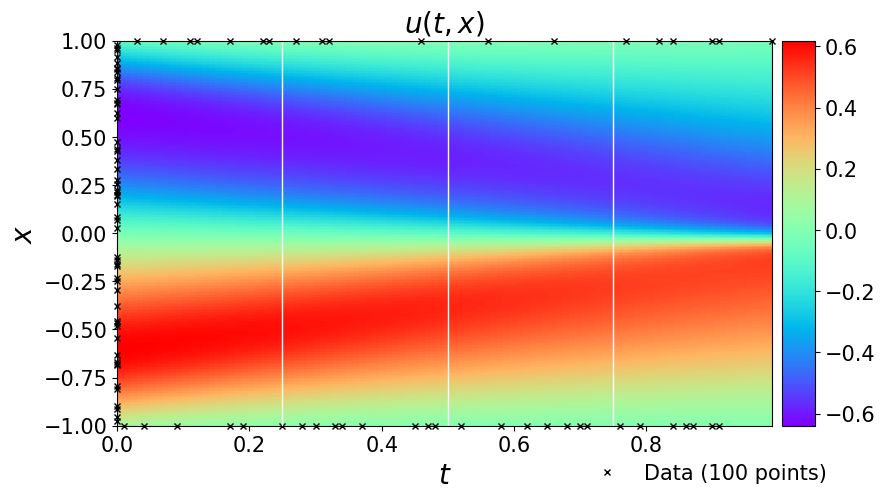

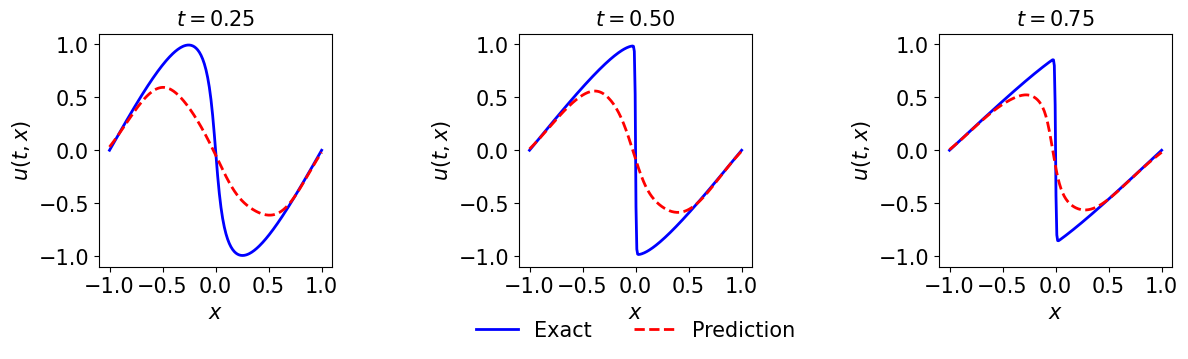

In [17]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

#first plot
U_pred = griddata(xt_sol, u_pred.flatten(), (X, T), method='cubic')

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t_sol.min(), t_sol.max(), x_sol.min(), x_sol.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    xt_train[:,1], 
    xt_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x_sol.min(), x_sol.max(), 2)[:,None]
ax.plot(t_sol[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t_sol[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t_sol[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()


#second plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)
ax.remove()

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x_sol,U_sol[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x_sol,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x_sol,U_sol[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x_sol,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x_sol,U_sol[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x_sol,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()